<img src="../img/hu-logo.png" align="right" width="120">

# Exercise 03: Dr. D's Grocery Store

## Help Dr. D to automate shopper segmentation

Dr. D is a marketing professor at a US business school and the proud owner of a small neighborhood grocery stores. As a marketing professor Dr. D undestands the value of data, so one of the first things after opening the grocery store was launching a loyalty card app. Customers can show the app at the checkout to collect loyalty points. After collecting enough loyalty points, customers can exchange their loyalty points for product vouchers that can be used to get grocery products for free. The customers love this concept, and Dr. wants to make the loyalty program even better by offering targeted coupons. He wants to use the loyalty program data to analyze the behavior (and preferences) of his customers. 

With the help of the consulting firm _Accidenture_ Dr. D created customer segments so he can recommend suitable products to customers. Dr. D. told us that working with _Accidenture_ is pretty expensive: once every quarter he hires two consultants for 3 days (USD 3,500 per consultant per day plus travel expenses) to segment the customers.

After working with _Accidenture_ for a few months, Dr. D has collected a lot of labeled data. Instead of paying consultants a lot of money, Dr. D wants to use Machine Learning to automate the customer segmentation so he can save some money to take his family on a (very!) nice vacation. Let's look at the data, perhaps we can produce a segmentation model helps Dr. D to save some money!

<img src=../img/grocery.png width=800>

## Setup

In [1]:
import os
import tqdm
import warnings
import functools

import numpy as np
import pandas as pd

import seaborn as sns
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.model_selection
import sklearn.metrics

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [2]:
sns.set(style="ticks")
sns.set_style("whitegrid")

plt.rcParams.update({
    "figure.figsize": (10, 8),
    "axes.titlesize": 20,
    "axes.labelsize": 15,
    "legend.fontsize": 15,
    "axes.grid": True,
    "axes.axisbelow": True,
    "pcolor.shading": "auto",
})

In [3]:
my_colors = [
    sns.color_palette()[0],
    sns.color_palette()[1],
    sns.color_palette()[2]
]

<br>
<br>
<br>

# Part 1: Exploratory Data Analysis

## Background `parquet`

- columnar storage nature of the format allows us to easily select a subset of columns for all rows
- binary format and allows encoded data types.
- metadata (schema at three levels: file, chunk, and page header)
- compression, encoding and splittable format for parallel and high throughput reads

## Data content

The dataset (450 shoppers) contains the following variables

- `shopper_id` (object): The loyalty program ID.
- `average_revenue` (float64): Average monthly spending in USD (i.e., revenue).
- `average_basket_size` (float64): Average basket size per shopping trip (i.e., number of SKUs purchased on a trip).
- `fraction_canned_food` (float64): Fraction of purchases that are canned food products.
- `fraction_national_brands` (float64): Fraction of purchases that are products manufacturered by national brands.
- `segment_name` (object): The segment each customer was assigned to by Accidenture.
- `is_cherry_picker` (int64): A binary indicator whether a customer is considered to be a "cherry picker" (nor relevant for today).

## Load data

In [4]:
df = pd.read_parquet("e03-dr-d-grocery.parquet")

In [5]:
df.head()

,shopper_id,average_revenue,average_basket_size,fraction_canned_food,fraction_national_brands,segment_name,is_cherry_picker
0,shopper_000,141.817975,3.541991,0.165028,0.077541,The Obnoxious Teens,0
1,shopper_001,144.396016,3.860022,0.163544,0.069220,The Obnoxious Teens,1
2,shopper_002,130.580378,3.761713,0.149754,0.067993,The Obnoxious Teens,0
3,shopper_003,167.258689,3.555836,0.145920,0.067840,The Obnoxious Teens,0
4,shopper_004,144.925715,4.021508,0.170981,0.078963,The Obnoxious Teens,0


In [6]:
df.describe()

,average_revenue,average_basket_size,fraction_canned_food,fraction_national_brands,is_cherry_picker
count,450.000000,450.000000,450.000000,450.000000,450.000000
mean,378.464356,23.884672,0.194487,0.067881,0.460000
std,182.141639,15.409354,0.028280,0.009784,0.498952
min,90.757119,1.769286,0.138783,0.043475,0.000000
25%,160.378473,6.059692,0.171622,0.061535,0.000000
50%,425.914019,26.463476,0.193793,0.067127,0.000000
75%,520.202382,36.533924,0.216222,0.073704,1.000000
max,759.837484,56.032508,0.266659,0.099542,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 149
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   shopper_id                450 non-null    object 
 1   average_revenue           450 non-null    float64
 2   average_basket_size       450 non-null    float64
 3   fraction_canned_food      450 non-null    float64
 4   fraction_national_brands  450 non-null    float64
 5   segment_name              450 non-null    object 
 6   is_cherry_picker          450 non-null    int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 28.1+ KB


## Meet the shoppers

In [8]:
df.groupby("segment_name").shopper_id.count()

segment_name
The Obnoxious Teens     150
The Prepper             150
The Shopper-for-Hire    150
Name: shopper_id, dtype: int64

### Shopper Type 1: The Prepper

<img src=../img/prepper.gif width="600">

### Shopper Type 2: The Obnoxious Teens

<img src=../img/teens.gif width="600">

### Shopper Type 3: The Shopper-for-Hire

<img src=../img/shopper-hire.gif width="600">

[(Source)](https://www.mandatory.com/living/1545648-10-kinds-of-shoppers-youll-encounter-coronavirus-pandemic#7)

## Data preparation

Let's put our `dict` skills to good use...

### Create mapping dict

In [9]:
map_segment_name_to_id = {
    name: ix
    for ix, name
    in enumerate(df.segment_name.unique())
}
map_segment_name_to_id

{'The Obnoxious Teens': 0, 'The Shopper-for-Hire': 1, 'The Prepper': 2}

### Create inverse mapping dict

In [10]:
map_segment_id_to_name = {
    map_segment_name_to_id[name]: name
    for name
    in map_segment_name_to_id
}
map_segment_id_to_name

{0: 'The Obnoxious Teens', 1: 'The Shopper-for-Hire', 2: 'The Prepper'}

### Apply mapping dict

In [11]:
df["segment_id"] = df.segment_name.map(map_segment_name_to_id)

In [12]:
df.head()

,shopper_id,average_revenue,average_basket_size,fraction_canned_food,fraction_national_brands,segment_name,is_cherry_picker,segment_id
0,shopper_000,141.817975,3.541991,0.165028,0.077541,The Obnoxious Teens,0,0
1,shopper_001,144.396016,3.860022,0.163544,0.069220,The Obnoxious Teens,1,0
2,shopper_002,130.580378,3.761713,0.149754,0.067993,The Obnoxious Teens,0,0
3,shopper_003,167.258689,3.555836,0.145920,0.067840,The Obnoxious Teens,0,0
4,shopper_004,144.925715,4.021508,0.170981,0.078963,The Obnoxious Teens,0,0


In [13]:
# some in-line tests
assert min(df.segment_id) == 0
assert max(df.segment_id) == (df.segment_id.nunique()-1)
assert np.all(df.segment_id.map(map_segment_id_to_name) == df["segment_name"])

### Define the response and feature variables 

- We only want to use the variables of interest for our prediction of customer segments
    - Fraction of bought items that are canned food (`fraction_canned_food`)
    - Fraction of bought items that are manufactured by national brands such as Coca-Cola (`fraction_national_brands`)
    - Average monthly revenue (`average_revenue`)
    - Average basket size per shopping trip (`average_basket_size`)
    
*We will look at the variable `is_cherry_picker` later ;)*

First, we'll study our data a bit more...

In [14]:
feature_variables = [
    "fraction_canned_food",
    "fraction_national_brands",
    "average_revenue",
    "average_basket_size",
]

## Let's start with some (meaningful) EDA

<img src=../img/data.png width="800">

Source: Sarstedt & Mooi (2019), p. 107

### Excursion: "Anscombe's quartet"

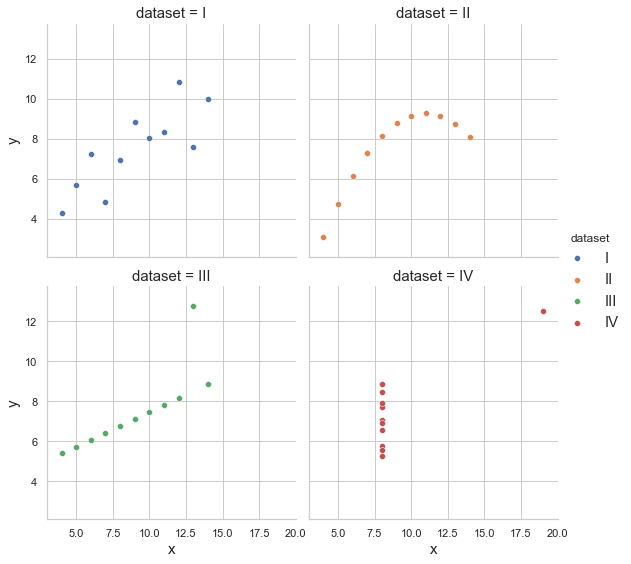

In [15]:
df_anscombe = sns.load_dataset("anscombe")

g = sns.FacetGrid(
    df_anscombe,
    col="dataset",
    col_wrap=2,
    hue="dataset",
    height=4
)
g.map(sns.scatterplot, "x", "y")
g.add_legend()

plt.xlim(df_anscombe.x.min()-1, df_anscombe.x.max()+1)
plt.ylim(df_anscombe.y.min()-1, df_anscombe.y.max()+1)

plt.show()

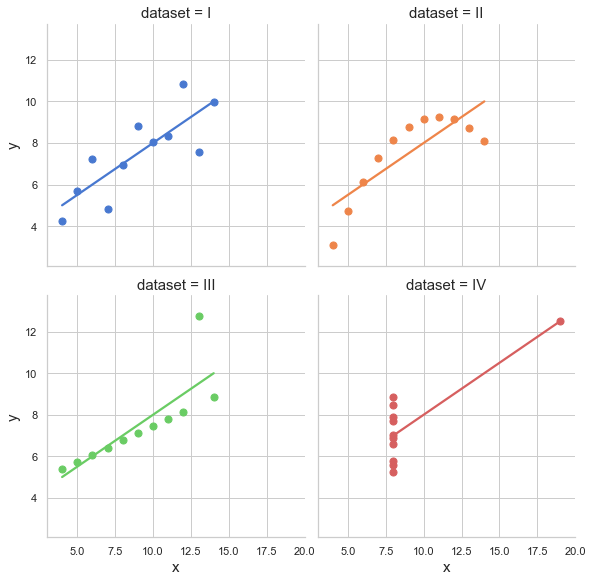

In [16]:
df_anscombe = sns.load_dataset("anscombe")

sns.lmplot(
    x="x",
    y="y",
    col="dataset",
    hue="dataset",
    data=df_anscombe,
    col_wrap=2,
    ci=None,
    palette="muted",
    height=4,
    scatter_kws={"s": 50, "alpha": 1}
)

plt.xlim(df_anscombe.x.min()-1, df_anscombe.x.max()+1)
plt.ylim(df_anscombe.y.min()-1, df_anscombe.y.max()+1)

plt.show()

Four data sets with identical
- Mean and sample variance of `x`
- Mean and sample variance of `y`
- Correlation between `x` and `y`
- Linear regression coefficients $\rho$
- Coefficient of determination $R^2$

### Descriptive Statistics

#### Median

The median is a value separating the higher half from the lower half of a data sample, a population or a probability distribution. For a data set, it may be thought of as "the middle" value.

In [17]:
df.groupby("segment_name")[feature_variables].median()

,fraction_canned_food,fraction_national_brands,average_revenue,average_basket_size
segment_name,,,,
The Obnoxious Teens,0.165538,0.074686,144.311948,4.125141
The Prepper,0.218525,0.065292,554.789159,40.089668
The Shopper-for-Hire,0.197005,0.062725,426.851005,26.463476


#### Mean

The arithmetic mean (or simply mean) of a sample ${\displaystyle x_{1},x_{2},\ldots ,x_{n}}$, usually denoted by ${\displaystyle {\bar {x}}}$, is the sum of the sampled values divided by the number of items in the sample

$
\quad {\displaystyle {\bar {x}} = {\frac {1}{n}}\left(\sum _{i=1}^{n}{x_{i}}\right) = {\frac {x_{1}+x_{2}+\cdots +x_{n}}{n}}}
$

In [18]:
df.groupby("segment_name")[feature_variables].mean()

,fraction_canned_food,fraction_national_brands,average_revenue,average_basket_size
segment_name,,,,
The Obnoxious Teens,0.166316,0.076007,146.388560,4.809775
The Prepper,0.219397,0.065914,560.418395,40.477877
The Shopper-for-Hire,0.197746,0.061723,428.586112,26.366364


#### Percentile

A percentile (or a centile) is a measure used in statistics indicating the value below which a given percentage of observations in a group of observations falls. For example, the 20th percentile is the value (or score) below which 20% of the observations may be found. Equivalently, 80% of the observations are found above the 20th percentile.

In [19]:
df.groupby("segment_name")[feature_variables].quantile(0.2)

,fraction_canned_food,fraction_national_brands,average_revenue,average_basket_size
segment_name,,,,
The Obnoxious Teens,0.156652,0.069348,128.032518,3.519291
The Prepper,0.201805,0.059816,492.909610,35.362656
The Shopper-for-Hire,0.182657,0.054378,379.708388,22.402460


In [20]:
df.groupby("segment_name")[feature_variables].quantile(0.8)

,fraction_canned_food,fraction_national_brands,average_revenue,average_basket_size
segment_name,,,,
The Obnoxious Teens,0.176707,0.083229,161.585923,6.618605
The Prepper,0.237711,0.071887,624.424567,46.229285
The Shopper-for-Hire,0.214967,0.068127,479.127021,29.853750


#### Variance

The variance of a random variable ${\displaystyle X}$ is the expected value of the squared deviation from the mean of ${\displaystyle X}$, ${\displaystyle \mu =\operatorname {E} [X]}$:

$
\quad {\displaystyle \operatorname {Var} (X)=\operatorname {E} \left[(X-\mu )^{2}\right]}
$

If the generator of random variable ${\displaystyle X}$ is discrete with probability mass function ${\displaystyle x_{1}\mapsto p_{1},x_{2}\mapsto p_{2},\ldots ,x_{n}\mapsto p_{n}}$, then

$
\quad {\displaystyle \operatorname {Var} (X)=\sum _{i=1}^{n}p_{i}\cdot (x_{i}-\mu )^{2}}
$

In [21]:
df.groupby("segment_name")[feature_variables].var()

,fraction_canned_food,fraction_national_brands,average_revenue,average_basket_size
segment_name,,,,
The Obnoxious Teens,0.000156,0.000071,437.857719,4.154882
The Prepper,0.000468,0.000058,5857.393119,41.576064
The Shopper-for-Hire,0.000352,0.000051,3597.623169,20.124759


In [22]:
df.groupby("segment_name")[feature_variables].std()**2

,fraction_canned_food,fraction_national_brands,average_revenue,average_basket_size
segment_name,,,,
The Obnoxious Teens,0.000156,0.000071,437.857719,4.154882
The Prepper,0.000468,0.000058,5857.393119,41.576064
The Shopper-for-Hire,0.000352,0.000051,3597.623169,20.124759


#### Range

Difference between min and max value.

$
\quad {\displaystyle {\Delta {x}} = \max(x) - \min(x)}
$

#### Mode

The mode is the value that appears most often in a set of data values. If $X$ is a discrete random variable, the mode is the value $x$ at which the probability mass function takes its maximum value.

### Boxplot

#### Definitions

<img src=../img/boxplot-definitions.png width="350">

#### Boxplot vs. probability density function of standard normal

<img src=../img/boxplot-pdf.png width="500">

with IQR = interquartile range

[(Source)](https://en.wikipedia.org/wiki/Box_plot)

#### For our data

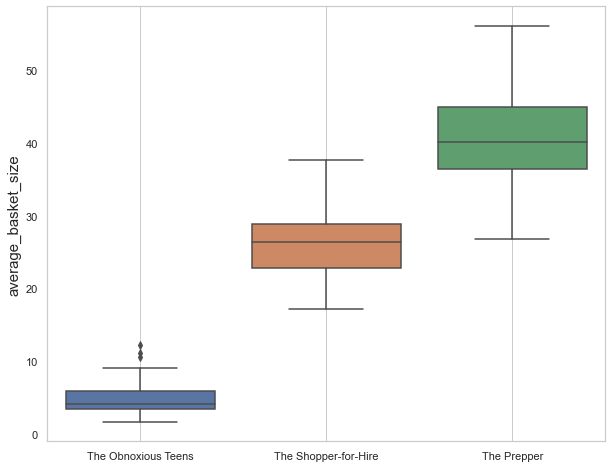

In [23]:
ax = sns.boxplot(
    x="segment_name",
    y="average_basket_size",
    data=df
)
plt.xlabel("")
plt.grid()

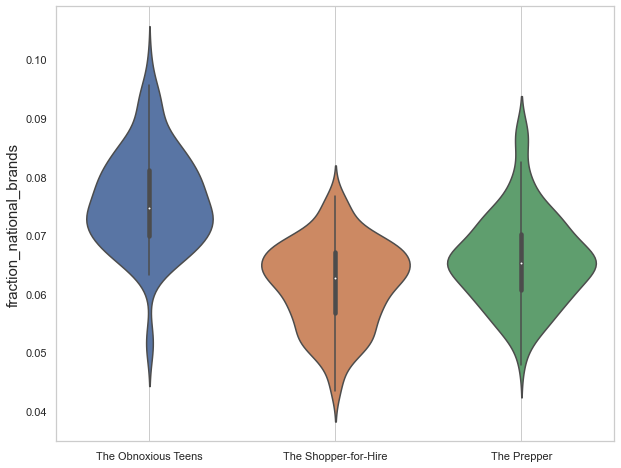

In [24]:
ax = sns.violinplot(
    x="segment_name",
    y="fraction_national_brands",
    data=df
)
plt.xlabel("")
plt.grid()

### Barplots and histograms

#### Barplot

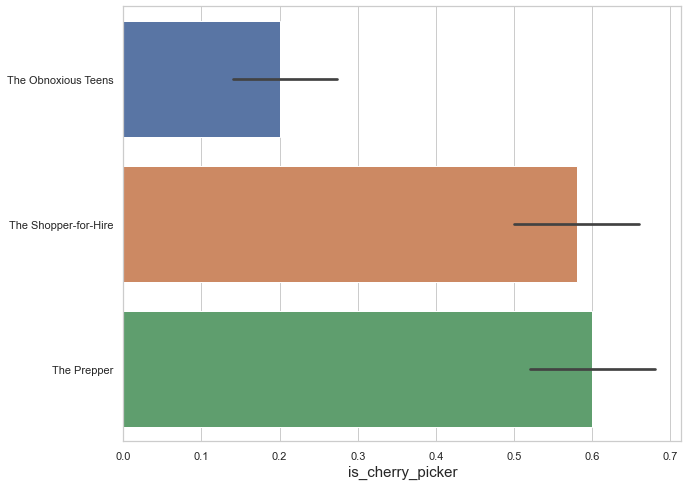

In [25]:
sns.barplot(
    data=df,
    x="is_cherry_picker",
    y="segment_name"
)
_ = plt.ylabel("")

#### Histogram

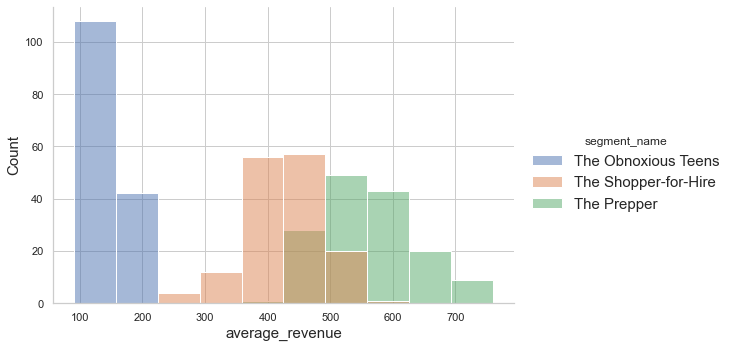

In [26]:
_ = sns.displot(
    df,
    x="average_revenue",
    hue="segment_name",
    height=5,
    aspect=1.5,
)

#### Empirical cumulative distributions

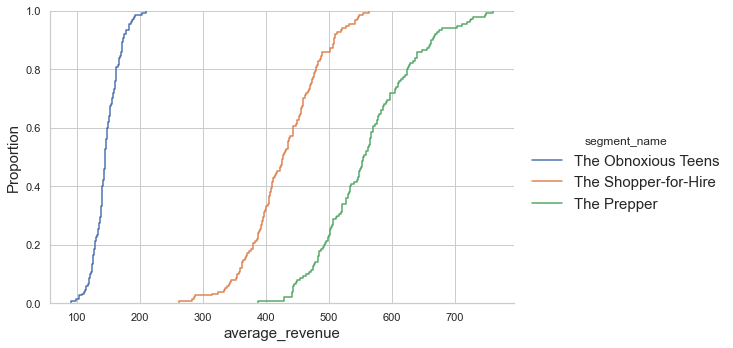

In [27]:
_ = sns.displot(
    df,
    x="average_revenue",
    hue="segment_name",
    kind="ecdf",
    height=5,
    aspect=1.5,
)

### Scatterplot

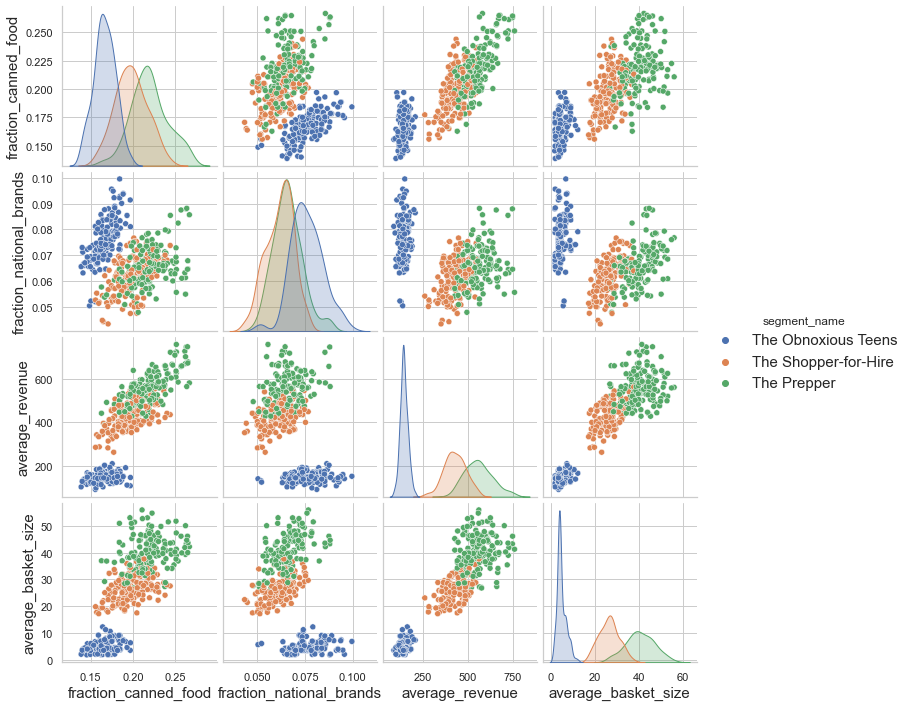

In [28]:
_ = sns.pairplot(
    df,
    vars=feature_variables,
    hue='segment_name'
)

### Covariance

In probability theory and statistics, covariance is a measure of the joint variability of two random variables. If the larger (smaller) values of one variable mainly correspond with the larger(smaller) values of the other variable the covariance is positive. In the opposite case, when the larger (smaller) values of one variable mainly correspond to the smaller (larger) values of the other the covariance is negative.

$
\quad {\displaystyle \operatorname {cov} (X,Y)} \\
\quad\quad = {\displaystyle\operatorname {E} {{\big [}(X-\operatorname {E} [X])(Y-\operatorname {E} [Y]){\big ]}}} \\
\quad\quad = {\displaystyle\frac {1}{n} \sum _{i=1}^{n}(x_{i}-E(X))(y_{i}-E(Y))}
$

The covariance is 0 if there is no relationship between the two variables.

### (Pearson) Correlation

Pearson's correlation coefficient is the covariance of the two variables divided by the product of their standard deviations:

$
\quad {\displaystyle \rho _{X,Y}={\frac {\operatorname {cov} (X,Y)}{\sigma _{X}\sigma _{Y}}}}
$

Other notable correlation coefficients: 
- Spearman's rank correlation coefficient for two ordinal variables
- Phi coefficient for two dichotomous variables
- Point-biserial correlation coefficient for one dichotomous variable

<br>
<br>
<br>

# Part 2: Binary Classification with k-NN


## Reminder: Types of machine learning

- Supervised learning uses labeled data
- Unsupervised learning uses unlabeled data

## We will use supervised ML to solve Dr. D's problem of classifying shoppers

**Objective** of supervised ML: Automate time-consuming or expensive manual tasks

__Requires__ labeled data
- Historical data with labels
- Experiments to get labeled data
- Crowd-sourcing labeled data

__Practical applications__
- Classification: should we target a consumer?
- Regression: how much revenue can we expect from a consumer?

Today, firms largely use (are biased towards) classification models. The reason behind this bias towards classification models is that most analytical problems involve making a decision that requires a simple Yes/No answer:
 - Will a customer churn or not
 - Will a customer respond to ad campaign or not
 - Will the firm default or not  

Such analysis are insightful and can be directly linked to an implementation roadmap.


## How k-NN works

**Simple idea:** Predict the label of a "point" $i$ by
1. finding the `k` _closest_ points to $i$ (the nearest neighbors)
2. looking up the labels of the the nearest neighbors
3. taking a majority vote

<img src=../img/starwars-startrek.png width="700">

`k` is a predefined hyperparameter. The algorithm depends on your choice of distance metric between the points in your sample.

### Create `X` and `y`

Let's create two arrays for our prediction problem
- The first array holds the segment data (our response variable).
- The second array holds the variables of interest (our feature variables).

_Remember our lecture, it's just different names:_
- Features = predictor variables = independent variables = `X`
- Target variable = dependent variable = response variable = `y`

In [29]:
df.head()

,shopper_id,average_revenue,average_basket_size,fraction_canned_food,fraction_national_brands,segment_name,is_cherry_picker,segment_id
0,shopper_000,141.817975,3.541991,0.165028,0.077541,The Obnoxious Teens,0,0
1,shopper_001,144.396016,3.860022,0.163544,0.069220,The Obnoxious Teens,1,0
2,shopper_002,130.580378,3.761713,0.149754,0.067993,The Obnoxious Teens,0,0
3,shopper_003,167.258689,3.555836,0.145920,0.067840,The Obnoxious Teens,0,0
4,shopper_004,144.925715,4.021508,0.170981,0.078963,The Obnoxious Teens,0,0


In [30]:
y = df["segment_id"].values
X = df[[
    "fraction_canned_food",
    "fraction_national_brands",
    "average_revenue",
    "average_basket_size"
]].values

print(f"Size dependent variable:      {y.shape}")
print(f"Size exaplanatory variables:  {X.shape}")

Size dependent variable:      (450,)
Size exaplanatory variables:  (450, 4)


## k-NN with sklearn

Build a model that can predict to which segment a customer belongs using K-Nearest Neigbors (k-NN)

### Configs

In [31]:
config_train_test_split = {
    "test_size": .3,    # fraction of observations assigned to the test set
    "random_state": 0,  # ensure reproducible random outcomes
}

config_knn_classifier = {
    "n_neighbors": 20,  # k
    "p": 2,             # euclidean distance
}

### In-sample predictions

In [32]:
config_knn_classifier

{'n_neighbors': 20, 'p': 2}

In [33]:
# initialize the KNeighborsClassifier with given config
knn = sklearn.neighbors.KNeighborsClassifier(**config_knn_classifier)

# fit the model|
_ = knn.fit(X, y)

In [34]:
example_shoppers = [0, 50, 100]
for shopper in example_shoppers:
    prediction_sample_0 = knn.predict(X[shopper].reshape(1, -1))[0]
    segment_name_0 = map_segment_id_to_name[prediction_sample_0]
    print(f"Prediction for sample {shopper:03d} (id, name): {prediction_sample_0, segment_name_0}")

Prediction for sample 000 (id, name): (0, 'The Obnoxious Teens')
Prediction for sample 050 (id, name): (1, 'The Shopper-for-Hire')
Prediction for sample 100 (id, name): (2, 'The Prepper')


### Out-of-sample predictions

In [35]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    y,
    **config_train_test_split
)

print(f"Size dependent variable (train):      {y_train.shape}")
print(f"Size exaplanatory variables (train):  {X_train.shape}")

print(f"Size dependent variable (test):       {y_test.shape}")
print(f"Size exaplanatory variables (test):   {X_test.shape}")

Size dependent variable (train):      (315,)
Size exaplanatory variables (train):  (315, 4)
Size dependent variable (test):       (135,)
Size exaplanatory variables (test):   (135, 4)


In [36]:
# initialize the KNeighborsClassifier with given config
knn = sklearn.neighbors.KNeighborsClassifier(**config_knn_classifier)

# fit the model
_ = knn.fit(X_train, y_train)

In [37]:
# Run prediction on test data
y_pred = knn.predict(X_test)

print("Test set predictions: \n {}".format(y_pred))

Test set predictions: 
 [2 1 2 2 1 2 0 1 2 1 1 0 1 0 0 0 2 0 0 2 1 0 1 2 2 1 0 2 1 2 2 1 0 0 1 1 2
 1 0 0 0 1 2 1 0 0 2 2 1 1 0 0 0 0 2 1 1 0 1 2 2 1 1 1 0 2 1 1 2 2 1 0 1 2
 1 1 0 2 1 2 0 2 0 1 2 0 0 0 2 1 0 1 1 0 0 2 0 0 1 2 2 2 0 2 0 1 1 2 0 0 1
 0 1 0 0 2 2 0 0 2 0 1 0 2 1 1 2 0 1 0 1 0 2 2 0]


In [38]:
# Calculate the accuracy of our prediction using np.mean
assert np.mean(y_pred==y_test) == knn.score(X_test, y_test)
print(f"Accuracy: {np.mean(y_pred==y_test):.4f}")

Accuracy: 0.9111


### Predicting the segment of a new customer

- Fraction canned food is 20%
- Fraction national brands is 25%
- Revenue is 50 Euro
- Number of items per trip is 10

In [39]:
def predict_wrapper(x):
    prediction = knn.predict(x)
    segment_name_prediction = map_segment_id_to_name[prediction[0]]
    print(f"Predicted segment for sample [{', '.join([str(x) for x in x[0]])}]: {segment_name_prediction}")

Let's create a new record and use our model that we have just built to predict the customers segment:

In [40]:
predict_wrapper(np.array([[0.2, 0.25, 50, 10]]))

Predicted segment for sample [0.2, 0.25, 50.0, 10.0]: The Obnoxious Teens


In [41]:
predict_wrapper(np.array([[0.2, 0.35, 550, 30]]))

Predicted segment for sample [0.2, 0.35, 550.0, 30.0]: The Prepper


## A minimal pipeline

In [42]:
def knn_pipeline(X_train, X_test, y_train, y_test, config_knn_classifier):
    # training
    knn = sklearn.neighbors.KNeighborsClassifier(**config_knn_classifier)
    knn.fit(X_train, y_train)
    
    # prediction
    y_pred = knn.predict(X_test)
    
    # benchmarking
    print(f"Accuracy: {np.mean(y_pred==y_test):.4f}")

In [43]:
knn_pipeline(X_train, X_test, y_train, y_test, config_knn_classifier)

Accuracy: 0.9111


### Background: Metrics

<img src="../img/confusion-multi.png" width="500">

Therefore,

$
\quad ACC = { \displaystyle\frac{ \displaystyle\sum_{i=1}^{N} Positives}{ N }} = { \displaystyle\frac{ \displaystyle\sum_{i=1}^{N} I( \hat{C_i} = C_i) } {N}}
$

## Scale variables

### Config

In [44]:
config_minmax_scale = {
    "feature_range": (0, 1)
}

config_scale = {
    "with_mean": True,
    "with_std": True,
}

### Do scaling

#### Min-Max

In [45]:
# mix-max scale the data between 0 and 1
X_scaled_01 = sklearn.preprocessing.minmax_scale(X_train, **config_minmax_scale)
X_scaled_01.mean(axis=0), X_scaled_01.std(axis=0)

(array([0.43699025, 0.3903184 , 0.43692604, 0.44119984]),
 array([0.21634703, 0.18644176, 0.27509875, 0.30043008]))

In [46]:
X_scaled_01.min(axis=0)

array([0., 0., 0., 0.])

In [47]:
X_scaled_01.max(axis=0)

array([1., 1., 1., 1.])

#### z-transform

Transform variable to have a mean of 0 and a standard deviation of 1:

$
\quad z_i = \displaystyle \frac {x_i - \bar x} {s}
$

with 
- z-transformed sample observations $z_i$
- original sample values $x_i$
- mean of the sample $\bar x$
- standard deviation of the sample $s$

In [48]:
# scale mean and standard deviation
X_scaled = sklearn.preprocessing.scale(X_train, **config_scale)
X_scaled.mean(axis=0), X_scaled.std(axis=0)

(array([-1.65652324e-15,  1.73899695e-15,  1.80878240e-15, -5.56873771e-17]),
 array([1., 1., 1., 1.]))

### Plot and compare

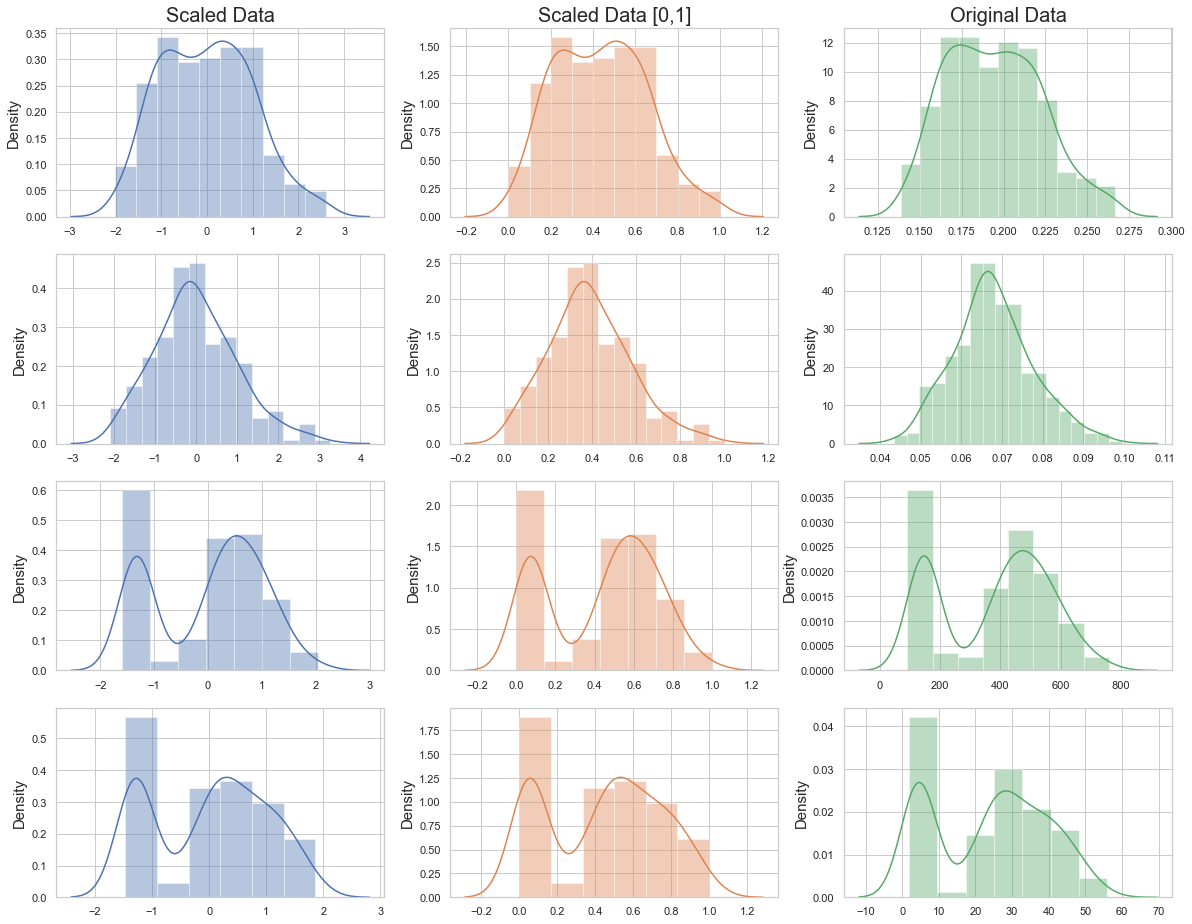

In [49]:
warnings.simplefilter(action="ignore", category=FutureWarning)

# Let's confirm that the distributions' shapes are unchanged
# plot both together to compare
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,16))

ax[0,0].set_title("Scaled Data", fontsize=20)
ax[0,1].set_title("Scaled Data [0,1]", fontsize=20)
ax[0,2].set_title("Original Data", fontsize=20)

for i in [0, 1, 2, 3]:
    sns.distplot(X_scaled[:, i], ax=ax[i, 0], color=my_colors[0])
    sns.distplot(X_scaled_01[:, i], ax=ax[i, 1], color=my_colors[1])
    sns.distplot(X[:, i], ax=ax[i, 2], color=my_colors[2])

plt.show()

# Technical Note: that the y-axis in a density plot is the probability density function for the kernel density estimation.

### What went wrong?

We did not scale the features in the test set.

In [50]:
knn_pipeline(X_scaled, X_test, y_train, y_test, config_knn_classifier)

Accuracy: 0.2889


### Let's fix this ...

In [51]:
X_train_scaled = sklearn.preprocessing.scale(X_train, **config_scale)
X_test_scaled = sklearn.preprocessing.scale(X_test, **config_scale)

X_train_scaled.mean(), X_test_scaled.mean(), X_train_scaled.std(), X_test_scaled.std()

(4.581872800040329e-16, 6.611994902212044e-16, 0.9999999999999999, 1.0)

In [52]:
knn_pipeline(X_train_scaled, X_test_scaled, y_train, y_test, config_knn_classifier)

Accuracy: 0.9630


### Why was this wrong?

We shouldn't scale the train and test set separately, we also need to learn the scaler on the training data!

In [53]:
X_train.mean(axis=0), X_train.std(axis=0)

(array([1.94663910e-01, 6.78317441e-02, 3.82259839e+02, 2.44176071e+01]),
 array([2.76655949e-02, 9.69696958e-03, 1.79203724e+02, 1.54221199e+01]))

In [54]:
X_test.mean(axis=0), X_test.std(axis=0)

(array([1.94072786e-01, 6.79963645e-02, 3.69608230e+02, 2.26411569e+01]),
 array([2.95602233e-02, 9.94831588e-03, 1.87869261e+02, 1.52499812e+01]))

### Now let's do it right!

Let's train the scaler properly, and predict the transformation on the test set. Note how the scaled test data does not have a mean of 0 and a standard deviation of 1.

In [55]:
scaler_mean_std = sklearn.preprocessing.StandardScaler(**config_scale)
_ = scaler_mean_std.fit(X_train)

In [56]:
X_train_scaled = scaler_mean_std.transform(X_train)

In [57]:
X_test_scaled = scaler_mean_std.transform(X_test)

In [58]:
X_train_scaled.mean(axis=0), X_train_scaled.std(axis=0)

(array([-1.65652324e-15,  1.73899695e-15,  1.80878240e-15, -5.56873771e-17]),
 array([1., 1., 1., 1.]))

In [59]:
X_test_scaled.mean(axis=0), X_test_scaled.std(axis=0)

(array([-0.02136676,  0.01697648, -0.07059903, -0.11518846]),
 array([1.0684832 , 1.02592009, 1.04835579, 0.9888382 ]))

In [60]:
knn_pipeline(X_train_scaled, X_test_scaled, y_train, y_test, config_knn_classifier)

Accuracy: 0.9556


## Improving our Prediction

There are a few obvious things we can easily change
- The input data
- The way we split our data into train and test
- The distribtution of segments (labels) within the train and test samples
- The value for k

### Fun with hyperparameters

Changing `k` leads to different results so what is the *"right"* value for k?

**Let's make the impact of setting k to different values visible:**
- Show boundaries of each class (i.e., segment) in a graph
- These "Decision Boundaries" separate our three segments from another 

#### Visualizing decision boundaries

100%|██████████| 6/6 [00:28<00:00,  4.77s/it]


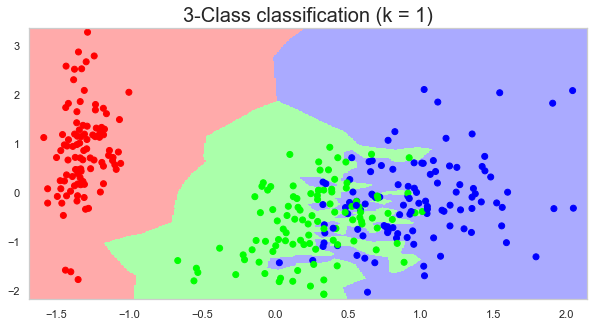

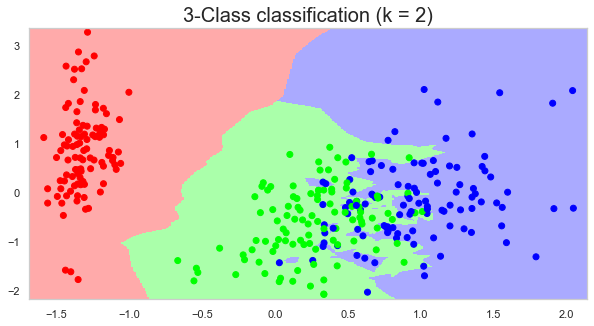

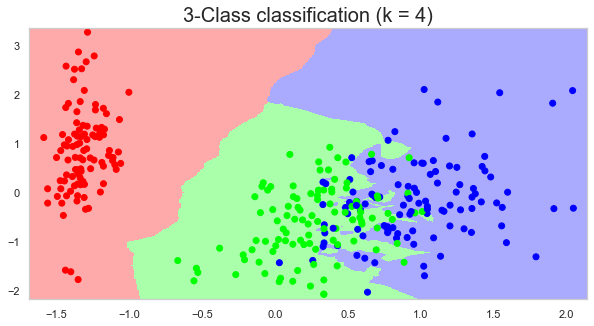

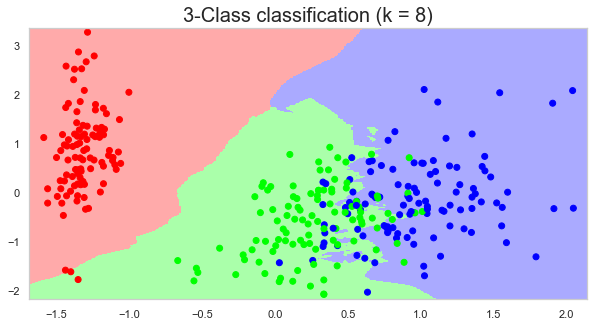

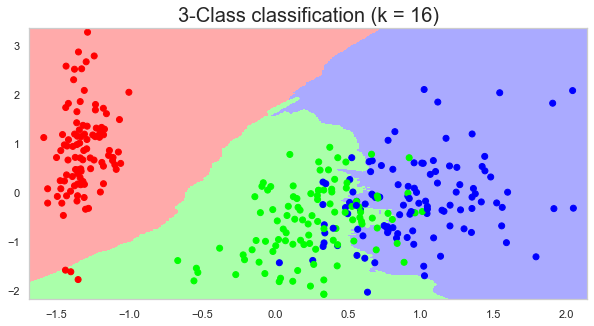

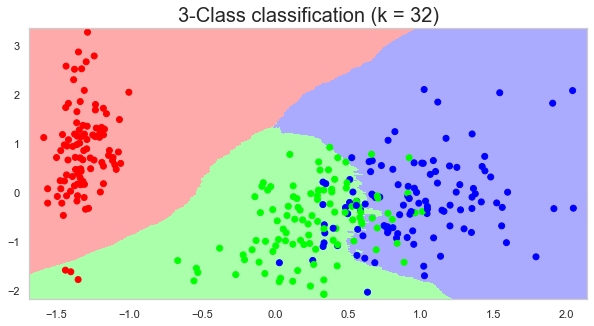

In [61]:
X2 = X_train_scaled[:, [2,1]]
y2 = y_train

h = .01  # step size in the mesh

# Create color maps
cmap_light = matplotlib.colors.ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = matplotlib.colors.ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

matplotlib.colors

for k in tqdm.tqdm([1, 2, 4, 8, 16, 32]):
    # we create an instance of Neighbours Classifier and fit the data.
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(X2, y2)

    # plot the decision boundary
    # by assigning a color to each point in the mesh [x_min, x_max] x [y_min, y_max]
    x_min, x_max = X2[:, 0].min() - .1, X2[:, 0].max() + .1
    y_min, y_max = X2[:, 1].min() - .1, X2[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,5))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X2[:, 0], X2[:, 1], c=y_train, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i)" % (k), fontsize=20)

plt.show()

#### What do you observe?

- As k gets larger, the boundaries become smoother
- As k approaches the number of customers, the whole graph will take on a single color

Model Complexity;
- Larger k = smoother decision boundary = less complex model
- Smaller k = more complex model = can lead to overfiting

Evaluate scores on hold-out data when varying `k` 

#### Grid search over `k`

In [62]:
def knn_pipeline(X_train, X_val, y_train, y_val, config_knn_classifier):
    knn = sklearn.neighbors.KNeighborsClassifier(**config_knn_classifier)
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_val = knn.predict(X_val)
    return np.mean(y_pred_train==y_train), np.mean(y_pred_val==y_val)

In [63]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X,
    y,
    **config_train_test_split
)

In [64]:
knn_pipeline_data = functools.partial(knn_pipeline, X_train, X_val, y_train, y_val)

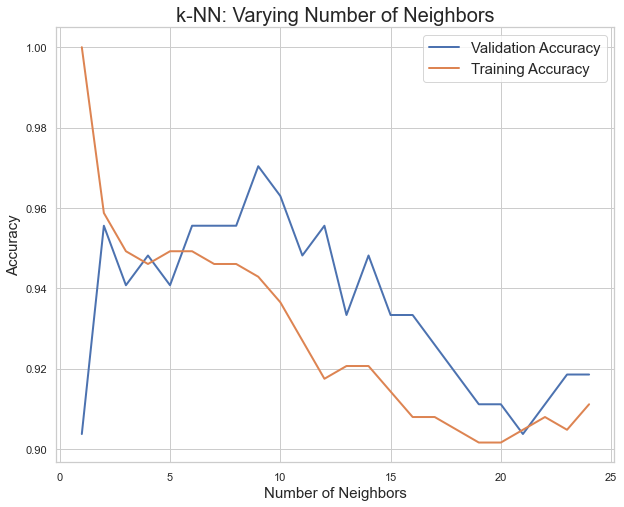

In [65]:
# setup arrays to store train and validation accuracies
neighbors = np.arange(1, 25)
train_accuracy = np.empty(len(neighbors))
val_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    config_knn_classifier_i = config_knn_classifier.copy()
    config_knn_classifier_i['n_neighbors'] = k
    train_accuracy[i], val_accuracy[i] = knn_pipeline_data(config_knn_classifier_i)

# Generate plot
plt.plot(neighbors, val_accuracy, linewidth=2, label="Validation Accuracy")
plt.plot(neighbors, train_accuracy, linewidth=2, label="Training Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.title("k-NN: Varying Number of Neighbors")
plt.show()

&mdash; <br>
Dr. Sebastian Gabel <br>
Machine Learning in Marketing &ndash; Exercise 3 <br>
2020 <br>